<a href="https://colab.research.google.com/github/mansikataria/FacialExpressionRecognition/blob/main/FERResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import pandas as pd
import os

In [2]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 200
batch_size = 32
start_epoch = 1  # start from epoch 0 
learning_rate_decay_start = 80  # 50
learning_rate_decay_every = 5 # 5
learning_rate_decay_rate = 0.9 # 0.9
lr = 0.01
use_cuda = True

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_PATH = '/content/drive/MyDrive/Colab Notebooks'
sys.path.insert(0,BASE_PATH)

Mounted at /content/drive


Reading the FER2013 dataset from the CSV

In [4]:
FER2013_PATH_FILE_NAME = 'fer2013.csv'
# data = pd.read_csv(BASE_PATH + '/' + FER2013_PATH_FILE_NAME)
# data.head(5)

In [5]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Import ResNet18 model from file

In [6]:
# upload external file before import
from google.colab import files
files.upload()
import resnet


Saving resnet.py to resnet.py


In [7]:
files.upload()
import utils

Saving utils.py to utils.py


In [8]:
model = resnet.ResNet18()

In [9]:
if use_cuda:
    model.cuda()

In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [13]:
from torch.autograd import Variable


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    global Train_acc
    model.train()
    train_loss = 0
    epoch_loss = 0
    correct = 0
    total = 0

    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = lr * decay_factor
        utils.set_lr(optimizer, current_lr)  # set the decayed rate
    else:
        current_lr = lr
    print('learning_rate: %s' % str(current_lr))

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        # print('targets: ', targets)
        # print('outputs: ', outputs)
        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        # print(loss.data)
        utils.clip_gradient(optimizer, 0.1)
        optimizer.step()
        # print(loss.data.shape)
        train_loss += loss.data
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        epoch_loss = train_loss/(batch_idx+1)
        utils.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_losses.append(epoch_loss)
    # print('loss: ', train_loss)
    Train_acc = 100.*correct/total
    train_acc.append(Train_acc)
    # print('train_acc: ', train_loss)

def PublicTest(epoch):
    global PublicTest_acc
    global best_PublicTest_acc
    global best_PublicTest_acc_epoch
    best_PublicTest_acc = 0
    best_PublicTest_acc_epoch = 0
    model.eval()
    PublicTest_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(PublicTestloader):
        # print(batch_idx)
        # bs, ncrops, c, h, w = np.shape(inputs)
        bs, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        outputs_avg = outputs.view(bs, 1, -1).mean(1)  # avg over crops
        loss = criterion(outputs_avg, targets)
        PublicTest_loss += loss.data
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        utils.progress_bar(batch_idx, len(PublicTestloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                           % (PublicTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    # Save checkpoint.
    PublicTest_acc = 100.*correct/total
    if PublicTest_acc > best_PublicTest_acc:
        print('Saving..')
        print("best_PublicTest_acc: %0.3f" % PublicTest_acc)
        state = {
            'net': model.state_dict() if use_cuda else model,
            'acc': PublicTest_acc,
            'epoch': epoch,
        }
        # if not os.path.isdir(path):
        #     os.mkdir(path)
        # torch.save(state, os.path.join(path,'PublicTest_model.t7'))
        best_PublicTest_acc = PublicTest_acc
        best_PublicTest_acc_epoch = epoch

def PrivateTest(epoch):
    global PrivateTest_acc
    best_PrivateTest_acc = 0
    best_PrivateTest_acc_epoch = 0
    model.eval()
    PrivateTest_loss = 0
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
        # bs, ncrops, c, h, w = np.shape(inputs)
        bs, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        outputs_avg = outputs.view(bs, 1, -1).mean(1)  # avg over crops
        loss = criterion(outputs_avg, targets)
        PrivateTest_loss += loss.data
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        epoch_loss = PrivateTest_loss / (batch_idx + 1)
        utils.progress_bar(batch_idx, len(PublicTestloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (epoch_loss, 100. * correct / total, correct, total))
    # Save checkpoint.
    PrivateTest_acc = 100.*correct/total
    val_losses.append(epoch_loss)
    val_acc.append(PrivateTest_acc)

    if PrivateTest_acc > best_PrivateTest_acc:
        print('Saving..')
        print("best_PrivateTest_acc: %0.3f" % PrivateTest_acc)
        state = {
            'net': model.state_dict() if use_cuda else model,
	        'best_PublicTest_acc': best_PublicTest_acc,
            'best_PrivateTest_acc': PrivateTest_acc,
    	    'best_PublicTest_acc_epoch': best_PublicTest_acc_epoch,
            'best_PrivateTest_acc_epoch': epoch,
        }
        # if not os.path.isdir(path):
        #     os.mkdir(path)
        # torch.save(state, os.path.join(path,'PrivateTest_model.t7'))
        best_PrivateTest_acc = PrivateTest_acc
        best_PrivateTest_acc_epoch = epoch


Define transformations

In [14]:
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [15]:
files.upload()
import dataset

Saving dataset.py to dataset.py


In [16]:
trainset = dataset.FER2013(BASE_PATH + '/' + FER2013_PATH_FILE_NAME, split = 'Train', transform=transformations)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size, num_workers=1)

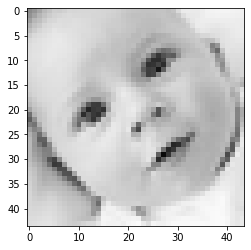

   Neutral


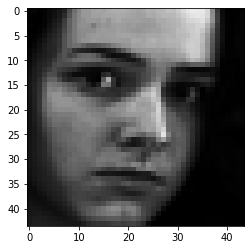

       Sad


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    # print(img.shape)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


for i in range(2):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    # print(images.shape)
    img = torchvision.utils.make_grid(images[0])
    # print(img.shape)
    # show images
    imshow(img)
    # print labels
    print(' '.join('%10s' % emotion_labels[labels[j]] for j in range(1)))

In [18]:
transformations = transforms.Compose([
    transforms.ToTensor()
])

In [19]:
PublicTestset = dataset.FER2013(BASE_PATH + '/' + FER2013_PATH_FILE_NAME, split = 'Public_Test', transform=transformations)
PublicTestloader = torch.utils.data.DataLoader(PublicTestset, batch_size=batch_size, shuffle=False, num_workers=1)
PrivateTestset = dataset.FER2013(BASE_PATH + '/' + FER2013_PATH_FILE_NAME, split = 'Private_Test', transform=transformations)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=batch_size, shuffle=False, num_workers=1)

In [20]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(start_epoch, num_epochs):
    train(epoch)
    PublicTest(epoch)
    PrivateTest(epoch)




Epoch: 1
learning_rate: 0.01
 [=============================>] | Loss: 1.675 | Acc: 32.687% (9384/28709) 898/898 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 [=============================>] | Loss: 1.674 | Acc: 34.216% (1228/3589) 113/113 
Saving..
best_PublicTest_acc: 34.216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 [=============================>] | Loss: 1.668 | Acc: 33.993% (1220/3589) 113/113 
Saving..
best_PrivateTest_acc: 33.993

Epoch: 2
learning_rate: 0.01
 [=============================>] | Loss: 1.338 | Acc: 48.173% (13830/28709) 898/898 
 [=============================>] | Loss: 1.451 | Acc: 44.859% (1610/3589) 113/113 
Saving..
best_PublicTest_acc: 44.859
 [=============================>] | Loss: 1.462 | Acc: 45.110% (1619/3589) 113/113 
Saving..
best_PrivateTest_acc: 45.110

Epoch: 3
learning_rate: 0.01
 [=============================>] | Loss: 1.207 | Acc: 54.317% (15594/28709) 898/898 
 [=============================>] | Loss: 1.184 | Acc: 55.336% (1986/3589) 113/113 
Saving..
best_PublicTest_acc: 55.336
 [=============================>] | Loss: 1.166 | Acc: 55.726% (2000/3589) 113/113 
Saving..
best_PrivateTest_acc: 55.726

Epoch: 4
learning_rate: 0.01
 [=============================>] | Loss: 1.135 | Acc: 56.944% (16348/28709) 898/898 
 [=============================>] | Loss: 1.

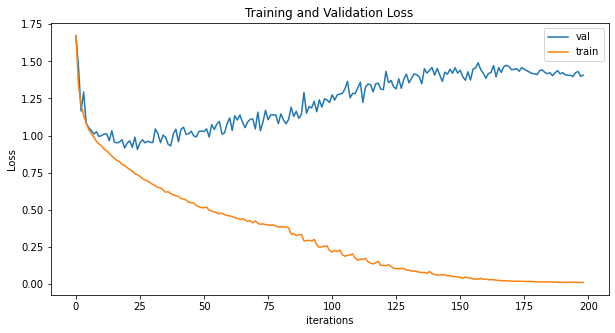

In [21]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

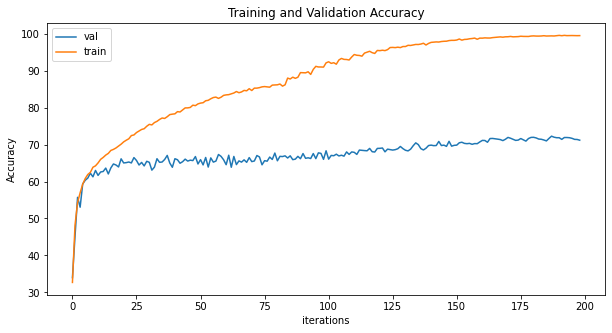

In [22]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()